### Predict DJ Moore Movement

CNN to create a spatial repersentation of the context data

Inject Context Embedding & Player Embeddings, early fusion for the player context 
and before the fully connected layer for the gloabl context. Use the CNN as a form of encoder, use a transpose CNN to find loss function

In [13]:
import pandas as pd
import numpy as np
import os

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Emory/NFL Lab/data')

import, normalize for direction

In [14]:
df = pd.read_csv('djM_games.csv')
df['play_id_n'] = df.groupby(['play_id', 'game_id']).ngroup()

#### 2d grid for cnn

In [15]:
def pixel_map(player_data, grid_width=121, grid_height=55, sigma=.8):
    
    # three channels, one for offense, one for defense, one for ball location
    pixel_map = np.zeros((3, grid_height, grid_width), dtype=np.float32)
    
    x_vals = player_data['x'].values
    y_vals = player_data['y'].values
    
    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        x_min = max(0, int(np.floor(x - 2*sigma)))
        x_max = min(grid_width, int(np.ceil(x + 2*sigma)) + 1)
        y_min = max(0, int(np.floor(y - 2*sigma)))
        y_max = min(grid_height, int(np.ceil(y + 2*sigma)) + 1)
        
        for xi in range(x_min, x_max):
            for yi in range(y_min, y_max):
                dist_sq = (xi - x)**2 + (yi - y)**2
                weight = np.exp(-dist_sq / (2 * sigma**2))
                
                if player_data.iloc[i]['player_side'] == 'Offense':
                    pixel_map[0, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Defense':
                    pixel_map[1, yi, xi] += weight
    
    ball_x = player_data['ball_land_x'].iloc[0]
    ball_y = player_data['ball_land_y'].iloc[0]
    
    ball_x_min = max(0, int(np.floor(ball_x - 2*sigma)))
    ball_x_max = min(grid_width, int(np.ceil(ball_x + 2*sigma)) + 1)
    ball_y_min = max(0, int(np.floor(ball_y - 2*sigma)))
    ball_y_max = min(grid_height, int(np.ceil(ball_y + 2*sigma)) + 1)
    
    for xi in range(ball_x_min, ball_x_max):
        for yi in range(ball_y_min, ball_y_max):
            dist_sq = (xi - ball_x)**2 + (yi - ball_y)**2
            weight = np.exp(-dist_sq / (2 * sigma**2))
            pixel_map[2, yi, xi] += weight
    
    return pixel_map

testing one play

In [16]:
df_play_id = df[df['play_id_n'] == 102]
df_grids_t= df_play_id.groupby(['play_id_n','frame_id']).apply(lambda x: pd.Series({'grid': pixel_map(x)}))

C:\Users\dalto\AppData\Local\Temp\ipykernel_28240\405905309.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids_t= df_play_id.groupby(['play_id_n','frame_id']).apply(lambda x: pd.Series({'grid': pixel_map(x)}))


grid for all plays

In [18]:
df_grids = df.groupby(['play_id_n','frame_id']).apply(lambda x: pd.Series({'grid': pixel_map(x)}))

C:\Users\dalto\AppData\Local\Temp\ipykernel_28240\1580485928.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids = df.groupby(['play_id_n','frame_id']).apply(lambda x: pd.Series({'grid': pixel_map(x)}))


In [19]:
df_grids = df_grids.reset_index()
df_grids = df_grids.sort_values(['play_id_n', 'frame_id'])

plot cords

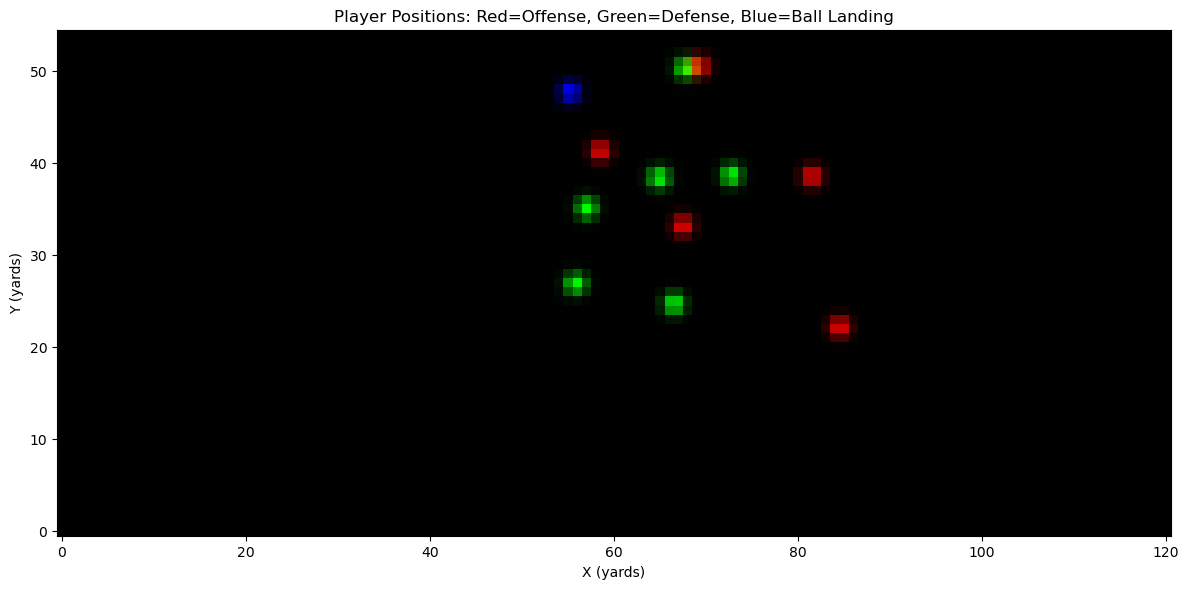

In [20]:
import matplotlib.pyplot as plt

sample_grid = df_grids_t['grid'].iloc[40]

combined = np.zeros((55, 121, 3))
combined[:, :, 0] = sample_grid[0] 
combined[:, :, 1] = sample_grid[1]  
combined[:, :, 2] = sample_grid[2]  

plt.figure(figsize=(12, 6), facecolor='white')
plt.imshow(combined, origin='lower')
plt.title('Player Positions: Red=Offense, Green=Defense, Blue=Ball Landing')
plt.xlabel('X (yards)')
plt.ylabel('Y (yards)')
plt.tight_layout()
plt.show()


In [21]:
df_grids.to_csv('encoded_location.csv')

#### CNN, Transformer

encoder, decoder, reconstruction loss

In [ ]:
import torch
import torch.nn as nn 

cnn to downsample heatmap

In [ ]:
class cnn_downsample(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.heatmap_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(32), # prevent exploding gradients
            nn.LeakyReLU(inplace=True), # preforms better on average idk if itll make a difference in this application

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.heatmap_encoder(x)
        return x
    

transformer encoder

In [ ]:
class encode_transformer(nn.Module):
    def __init__(self):
        super().__init__() # parent class

    def forward(self, x):
        
        return x
